### Quick tutorial on data fitting

To fit data there are basically two main steps. 

<ol>
    <li> <b>pick a function/model that looks like it might be a good representation of the data</b> </li>
    <li> <b>pick a cost function </b></li>
</ol>

These step apply regardless of the complexity of the data. You always need a function or model to fit and a measure of the error (cost function). Fitting data essentially revolves around finding the right parameters that minimize the error. This error is defined by a cost function of your choosing. These are two of the most widely used: <b>sum squared error (SSE)</b> and <b>negative log likelihood</b>. 


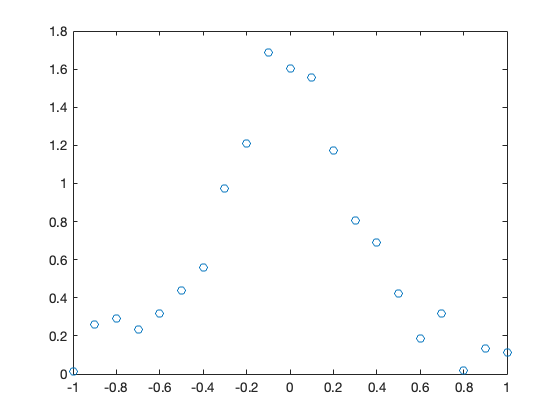

In [37]:
% lets generate some fake data with a gaussian shape 
xvals = -1:0.1:1; % x axis 
% we're going to perturb the data with some noise to make the fitting a bit harder
% the data remains gaussian but it wont be a perfect fit (no function ever is)
data = normpdf(-1:0.1:1,0,0.25)+(0.3*rand(length(xvals),1))'; % fake data
plot(xvals,data,'o');

In [2]:
% now that we have some fake data we have to follow steps 1 and 2. 
% First we pick the function we want to fit, in this case its obvious the data should be fit with a gaussian
% second we pick a cost function. In this case since were using fake data and have no individual responses its 
% easiest to fit using sum squared error. 

% now lets write the needed function
% importantly the first output of your function should be the error 

## 1) Fitting via SSE 

In [38]:
%%file gaussfit.m
function [sse,fit] = gaussfit(x,par,y)
    
    mu     = par(1); % controls the center
    sigma  = par(2); % controls the width
    
   fit = exp(-(x-mu).^2/(2*sigma^2)); % equation of gaussian

   if nargin == 3
       sse = sum((y-fit).^2);
   else
       sse = NaN;
   end
end

Created file '/Users/antonio/gaussfit.m'.


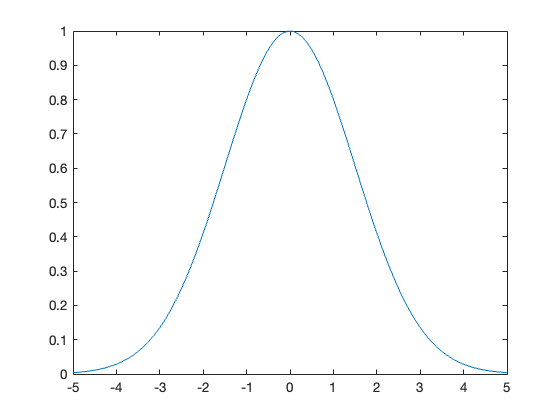

In [39]:
% Now we can test the function and see if it works
% lets define a new x and give it parameters
x = linspace(-5,5,100);
par = [0,1.5]; % center and width in that order

[~,test_func] = gaussfit(x,par);
plot(x,test_func,'-');

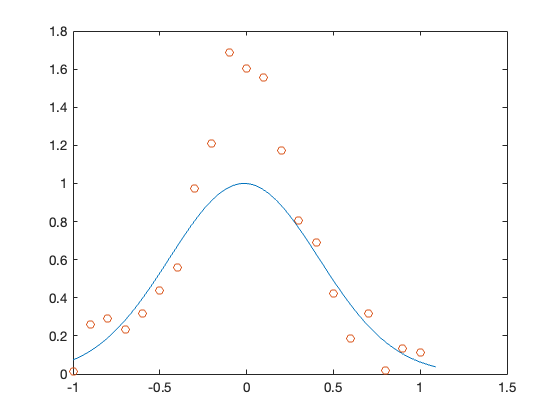

In [40]:
% now that we have our function working its time fit and find the parameters that best represent the data
% to do this we use MATLAB's fmincon function which is a function minimizer with constraints. The constraints in 
% this case are give by ub and lb which are the chosen parameter bounds for each parameter in this case the center
% and width of the gaussian. [lb=lower bound; ub = upper bound]

opt = optimoptions('fmincon','Algorithm','interior-point','Display','off');
ub = [ 1,    3]; %center; sigma; 
lb = [-1, 0.25]; %center; sigma; 
x0 = [0.5, 1];% starting points   

% the function you want to fit
f = @(par)gaussfit(xvals, par, data); 

% find the best fitting parameters using fmincon
[par,fval,exitflag,output,grad,hessian] = fmincon(f,x0,[],[],[],[],lb,ub,[],opt); 

%evaluate the function with the best fit parameters. 
% You can also now interpolate the x-axis to smooth the function
n_xvals = interp(xvals,10);
[sse,fit] = gaussfit(n_xvals, par);  

% plot the fit and the data superimposed
plot(n_xvals,fit,'-'); hold on
plot(xvals, data, 'o');

In [11]:
% you'll notice that the function is not a good fit. Why is this? As you can see a gaussian in its most basic
% form, does not exceed an amplitude of 1, because our data does, we need to account for this by adding an extra 
% parameter to our function. We'll call this parameter amp (short for amplitude) and it will scale the gaussian 
% allowing its amplitude to exceed 1.
% lets ammend our previous function and re-fit

In [43]:
%%file gaussfit.m
function [sse,fit] = gaussfit(x,par,y)
    
    mu     = par(1); % controls the center
    sigma  = par(2); % controls the width
    amp    = par(3); % controls the amplitude <----------
    
   fit = amp*(exp(-(x-mu).^2/(2*sigma^2))); % equation of gaussian

   if nargin == 3
       sse = sum((y-fit).^2);
   else
       sse = NaN;
   end
end

Created file '/Users/antonio/gaussfit.m'.


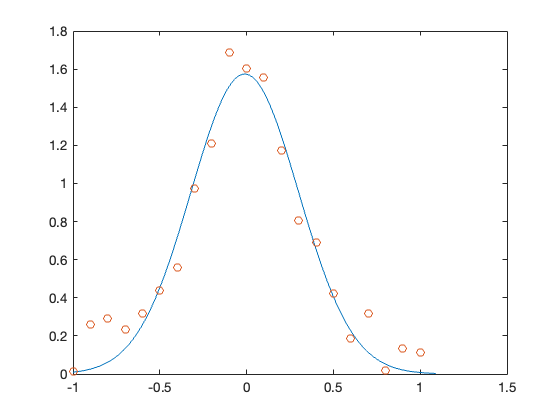

In [44]:
% lets re-fit the data and see if the fit improves with this newly added parameter!
opt = optimoptions('fmincon','Algorithm','interior-point','Display','off');
ub = [ 1,    3,5]; %center; sigma; amplitude
lb = [-1, 0.25,1]; %center; sigma; amplitude
x0 = [0.5, 1,1];% starting points   

% the function you want to fit
f = @(par)gaussfit(xvals, par, data); 

% find the best fitting parameters using fmincon
[par,fval,exitflag,output,grad,hessian] = fmincon(f,x0,[],[],[],[],lb,ub,[],opt); 

%evaluate the function with the best fit parameters. 
% You can also now interpolate the x-axis to smooth the function
n_xvals = interp(xvals,10);
[sse,fit] = gaussfit(n_xvals, par);  

% plot the fit and the data superimposed
plot(n_xvals,fit,'-'); hold on
plot(xvals, data, 'o');

In [14]:
% As you can see, the fit is now much better! Something you can test yourself is what happens 
% if some of the data points are negative. As you can see the gaussian by default starts at 0. What if 
% your data start at -1? A good exercise would be to add another parameter that can control for this.
% Additionally, by visual interpretation of the data there is one parameter than can be fixed rather than free.
% Generally, the fewer free parameters the better, try to spot which one should be fixed!

## Fitting via negative log likelihood (nLL)

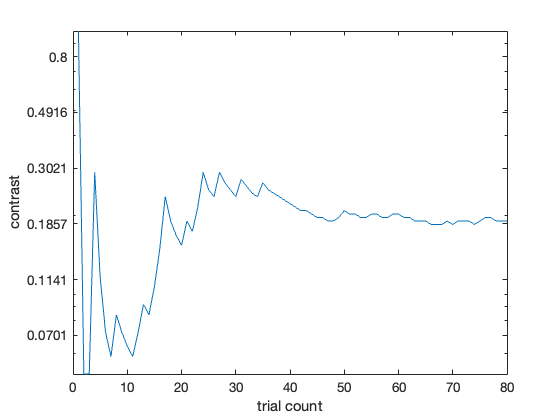

In [21]:
% To fit via nLL we need single trial data 
% for this example lets validate and adaptive staircase method
% lets say we have staircase data for an observer:

trialsMat = expt.trialStore(expt.trialStore(:,1)~=0,:);
semilogy(trialsMat(:,5)); ylabel('contrast'); xlabel('trial count')
yticks(logspace(log10(0.01),log10(0.8),10));

% in this case it looks like the staircase converged around 20% contrast
% something we can do is fit a psychometric function to the single trial data and see
% if the threshold we acquire is similar to the final point of the staircase (which should indeed be the case)

We can compute nLL as such:    $logL(c)=-(nlog(y)+(m-n)log(1-y))$ In this case $n$ is # of correct trials and $m$ is the total # of trials. Were going to fit a log Weibull function or Gumble but the principle carries over to any other psychometric function

In [29]:
%%file l_Weibull.m
function [nll,func] = l_Weibull(c,par,val)
        % fits dprime
        %   gamma  = guess rate
        %   lambda = lapse rate
        %   alpha  = threshold
        %   beta   = slope
        % @author: antonio fernandez
        
        gamma = 0.5;
        % all other parameters are free
        lambda = par(1);
        alpha  = par(2);
        beta   = par(3);
        % Gumbel function
        func = gamma+(1 - gamma - lambda).*(1-exp(-10.^(beta.*(c-alpha))));
        

        if nargin == 3
                % calculate error via negative log likelihood (nll)
            nll = sum(-(val.n'.*log(func)+(val.m-val.n)'.*log(1-func))); 
            
        else
            nll = NaN;
        end
end

Created file '/Users/antonio/l_Weibull.m'.


In [30]:
% contrast levels
c_lvls = unique(trialsMat(:,5));

for ii = 1:length(c_lvls)
    val.n(ii) = sum(trialsMat(trialsMat(:,5)==c_lvls(ii),7));
    val.m(ii) = length(trialsMat(trialsMat(:,5)==c_lvls(ii),7));
end
accuracy = val.n./val.m;

Normally, the data is grouped into bins. In this case contrast levels that are very close are grouped together. This helps visually see whether the fit is good or not as of course clusters of data will better inform the fit.

In [31]:
%% bin the data (for looks only)
bins =8; % this is arbitrary
steps = logspace(log10(c_lvls(1)),log10(c_lvls(end-1)),bins); % number of bins
for jj = 1:length(steps)
    if jj == 1
        binsIdx = c_lvls<=steps(jj);
    else
        binsIdx = c_lvls<=steps(jj) & c_lvls>steps(jj-1);
    end
    c(jj)=mean(c_lvls(binsIdx));
    cor(jj)=mean(accuracy(binsIdx));
    mw(jj)= sum(val.m(binsIdx));
end

Your initial point x0 is not between bounds lb and ub; FMINCON
shifted x0 to strictly satisfy the bounds.

                                            First-order      Norm of
 Iter F-count            f(x)  Feasibility   optimality         step
    0       4    5.625206e+01    0.000e+00    1.814e+02
    1       8    4.507759e+01    0.000e+00    4.058e+01    3.863e-01
    2      12    4.333537e+01    0.000e+00    1.226e+00    4.257e-01
    3      17    4.324814e+01    0.000e+00    3.180e+00    6.047e-02
    4      21    4.291255e+01    0.000e+00    1.176e+01    8.954e-01
    5      25    4.229200e+01    0.000e+00    1.069e+01    2.250e+00
    6      29    4.222699e+01    0.000e+00    6.795e+00    3.048e-02
    7      33    4.222171e+01    0.000e+00    1.743e-01    1.099e-01
    8      37    4.215751e+01    0.000e+00    1.610e+00    3.490e-01
    9      41    4.213104e+01    0.000e+00    8.144e-02    1.132e-01
   10      45    4.210175e+01    0.000e+00    8.788e-02    1.806e-01
   11    

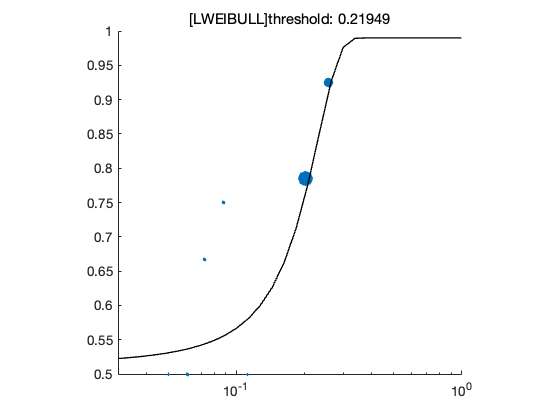

In [33]:
% fit the data with Gumbel (log-Weibull)
opt = optimoptions('fmincon', 'Algorithm', 'interior-point','Display','iter', 'MaxIter', 5000);
xx = logspace(log10(0.03), log10(c_lvls(end)), 30); % transform to log the interpolation
ub = [0.05,c_lvls(end),7];     %lambda; alpha; beta
lb = [0.01,c_lvls(1),2];
x0 = [0.02,c_lvls(3),2];
f = @(par)l_Weibull(c_lvls,par,val);
[par,fval,exitflag,output,grad,hessian] = fmincon(f,x0,[],[],[],[],lb,ub,[],opt);
[nll, realfunc] = l_Weibull(c_lvls,par,val); %actual fit
[~, func] = l_Weibull(xx,par); % interpolate fit

% plot the data
scatter(c,cor,mw*3,'o','filled'); hold on
semilogx(xx,func,'k-','linewidth',1); 
set(gca, 'XScale', 'log');

title(['[LWEIBULL]threshold: ', num2str(par(2))]);
ylim([0.5 1]); axis square

Now lets see all the data points instead of the binned data. 

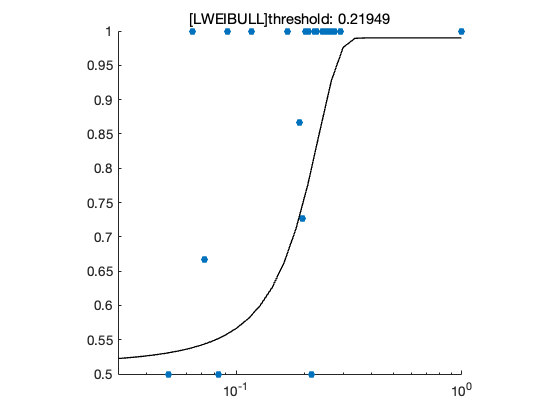

In [34]:
% plot the data
scatter(c_lvls,accuracy,30,'o','filled'); hold on
semilogx(xx,func,'k-','linewidth',1); 
title(['[LWEIBULL]threshold: ', num2str(par(2))]);
set(gca, 'XScale', 'log');
ylim([0.5 1]); axis square

As you might have imagined, its difficult to see if this is a good fit without binning the data. As you can see the estimated threshold from the initial adaptive staircase is very similar to the one we estimated by fitting a psychometric function